# Load Cleaned Sensory Data Collected by master_script
This note shows cleaned data.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker

import pandas as pd
import numpy as np
from datetime import datetime
import csv
import cv2

import os
import glob

import pdb

In [2]:

raw_sensor_data_files = glob.glob('raw_sensor_data_from_master_script_clean/*.csv')
raw_sensor_data_files.sort()
raw_sensor_data = {}
for file in raw_sensor_data_files:
    print('Loading: {}'.format(file))
    # 1. load sensro data
    raw_sensor_data[file] = pd.read_csv(file)
    

Loading: raw_sensor_data_from_master_script_clean/01_sensor_data__September_14_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/02_sensor_data__September_17_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/03_sensor_data__September_18_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/04_sensor_data__September_19_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/05_sensor_data__September_20_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/06_sensor_data__September_21_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/07_sensor_data__September_24_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/08_sensor_data__September_25_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/09_sensor_data__September_26_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/10_sensor_data__September_27_201

# Plot Data For Each Day

In [3]:
def separate_data_from_different_behavior(raw_sensor_data, date,
                                          experiment_schedule_table = 'experiment_schedule_table.csv'):
    """
    Args:
        raw_sensor_data (pd.DataFrame): sensor data collect in one day
        experiment_schedule_table (string): file name of experiment schedule table which contains schedule of 
            each day's experiments in where:
                0: Prescribed_Behavior
                1: Parameterized_Learning_Agent
                2: Single_Agent_Raw_Act
                3: Agent_Community_Raw_Act
    Return:
        separated_data (dict): key is the phase name, and value is the data.
        phase_code (dict): key is the phase name, and value is the phase code.
    """
    # read experiment schedule file and retrive the schedule of date
    experiment_schedule = pd.read_csv(experiment_schedule_table)
    phaseschedule = experiment_schedule.loc[experiment_schedule['Date'] == date]
    # read schedule code in each interaction phase
    phase_1pm_2pm_code = phaseschedule['1pm-2pm'].values
    phase_2pm_2_30pm_code = phaseschedule['2pm-2:30pm'].values
    phase_2_30pm_3pm_code = phaseschedule['2:30pm-3pm'].values
    phase_3pm_4pm_code = phaseschedule['3pm-4pm'].values
    # separate data
    date, time = raw_sensor_data['timestamp'][0].split(' ')
    
    phase_1pm_2pm_data = raw_sensor_data.loc[(raw_sensor_data['timestamp'] >= date+' '+'13:00:00') & (raw_sensor_data['timestamp'] <= date+' '+'14:00:00')]
    phase_2pm_2_30pm_data = raw_sensor_data.loc[(raw_sensor_data['timestamp'] >= date+' '+'14:00:00') & (raw_sensor_data['timestamp'] <= date+' '+'14:30:00')]
    phase_2_30pm_3pm_data = raw_sensor_data.loc[(raw_sensor_data['timestamp'] >= date+' '+'14:30:00') & (raw_sensor_data['timestamp'] <= date+' '+'15:00:00')]
    phase_3pm_4pm_data = raw_sensor_data.loc[(raw_sensor_data['timestamp'] >= date+' '+'15:00:00') & (raw_sensor_data['timestamp'] <= date+' '+'16:00:00')]
    
    phase_data = {}
    phase_code = {}
    # combine phase with the same phase_code
    if (phase_1pm_2pm_code == phase_2pm_2_30pm_code) and (phase_2_30pm_3pm_code == phase_3pm_4pm_code):
        phase_data['phase_1pm_2_30pm'] = pd.concat([phase_1pm_2pm_data, phase_2pm_2_30pm_data])
        phase_data['phase_2_30pm_4pm'] = pd.concat([phase_2_30pm_3pm_data, phase_3pm_4pm_data])
        
        phase_code['phase_1pm_2_30pm'] = phase_1pm_2pm_code
        phase_code['phase_2_30pm_4pm'] = phase_2_30pm_3pm_code
    elif (phase_2pm_2_30pm_code == phase_2_30pm_3pm_code) and (phase_1pm_2pm_code != phase_2pm_2_30pm_code):
        phase_data['phase_2pm_3pm'] = pd.concat([phase_2pm_2_30pm_data, phase_2_30pm_3pm_data])
        phase_data['phase_1pm_2pm'] = phase_1pm_2pm_data
        phase_data['phase_3pm_4pm'] = phase_3pm_4pm_data
        
        phase_code['phase_2pm_3pm'] = phase_2pm_2_30pm_code
        phase_code['phase_1pm_2pm'] = phase_1pm_2pm_code
        phase_code['phase_3pm_4pm'] = phase_3pm_4pm_code
    elif (phase_1pm_2pm_code == phase_2pm_2_30pm_code) and (phase_2pm_2_30pm_code == phase_2_30pm_3pm_code):
        phase_data['phase_1pm_3pm'] = pd.concat([phase_1pm_2pm_data, phase_2pm_2_30pm_data, phase_2_30pm_3pm_data])
        phase_data['phase_3pm_4pm'] = phase_3pm_4pm_data
        
        phase_code['phase_1pm_3pm'] = phase_1pm_2pm_code
        phase_code['phase_3pm_4pm'] = phase_3pm_4pm_code
    else:
        print('phase_1pm_2pm_code:{} phase_2pm_2_30pm_code:{}  phase_2_30pm_3pm_code: {} phase_3pm_4pm_code:{}'.format(phase_1pm_2pm_code,phase_2pm_2_30pm_code,phase_2_30pm_3pm_code,phase_3pm_4pm_code))
        raise Exception('Check {} to spot the error.'.format(experiment_schedule_table))
    
    return phase_data, phase_code
    
def plot_reward_signal(raw_sensor_data, filename):
    """
    Args:
        raw_sensor_data (pd.DataFrame): the data
        filename (string): the name of the date file
    """
    ymin=0
    ymax=3
    ystep=0.2
    
    # separate data from different behavior
    # find the date of raw_sensor_data
    _, date = filename.split('_2018')[0].split('sensor_data__')
    print(date)
    phase_data, phase_code = separate_data_from_different_behavior(raw_sensor_data, date,
                                                                   experiment_schedule_table = 'experiment_schedule_table.csv')
    print('Separate data done!')
    #pdb.set_trace()
    
    # plot data
    plt.figure()
    legend_label = []
    for phase_name in phase_data.keys():
        if phase_code[phase_name] == 0:   # Prescribed_Behavior
            color = 'k'
            legend_label.append('Prescribed_Behavior')
        elif phase_code[phase_name] == 1: # Parameterized_Learning_Agent
            color = 'r'
            legend_label.append('Parameterized_Learning_Agent')
        elif phase_code[phase_name] == 2: # Single_Agent_Raw_Act
            color = 'b'
            legend_label.append('Single_Agent_Raw_Act')
        else:                             # Agent_Community_Raw_Act
            color = 'g'
            legend_label.append('Agent_Community_Raw_Act')
        time_series = pd.to_datetime(phase_data[phase_name]['timestamp'])
        plt.plot(time_series, phase_data[phase_name]['reward_IR_distance'], color = color, lw=1, alpha=0.8)
        
    plt.legend(legend_label)
    
    plt.xlabel('time')
    plt.ylabel('reward')
    plt.ylim(ymin, ymax, ystep)
    locs, labels = plt.xticks(rotation=30, fontsize = 12)
    # Set scond x-axis
    ax1 = plt.gca()
    ax2 = ax1.twiny()
    ax2.plot(np.arange(len(raw_sensor_data)), np.zeros(len(raw_sensor_data)))
    ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
    ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
    ax2.spines['bottom'].set_position(('outward', 60))
    ax2.set_xlabel('step')

    plt.title('Reward: {}'.format(date))
    plt.grid(True, linestyle=':')
    plt.tight_layout()

September_14
Separate data done!


<IPython.core.display.Javascript object>


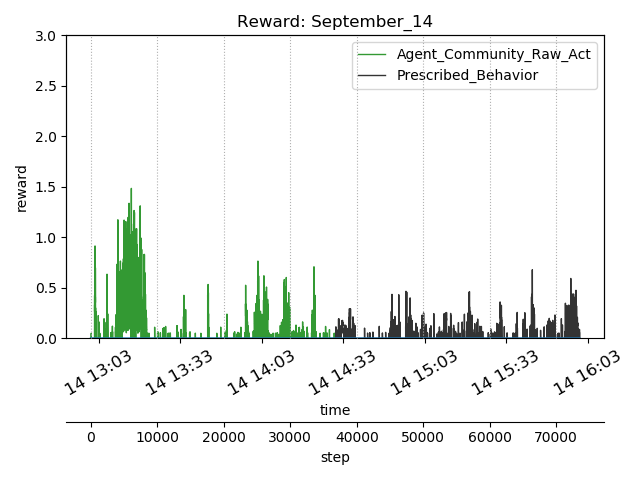

September_17
Separate data done!


<IPython.core.display.Javascript object>


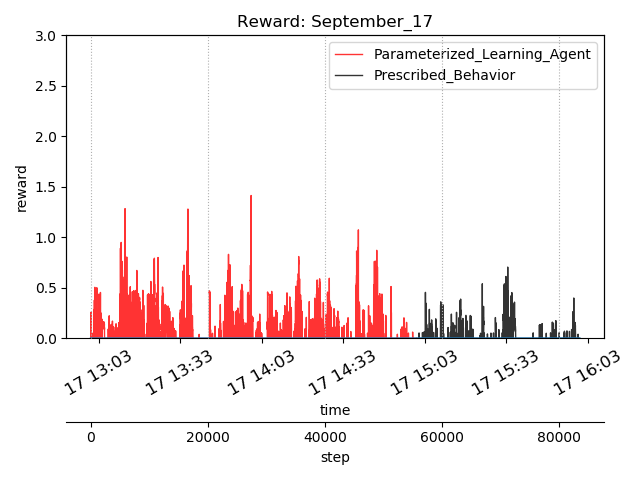

September_18
Separate data done!


<IPython.core.display.Javascript object>


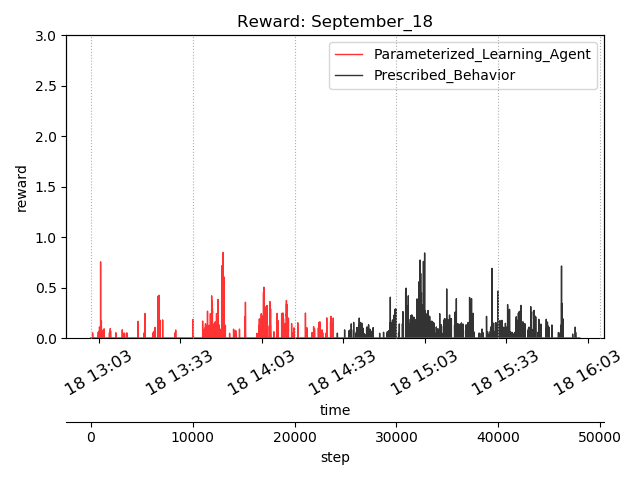

September_19
Separate data done!


<IPython.core.display.Javascript object>


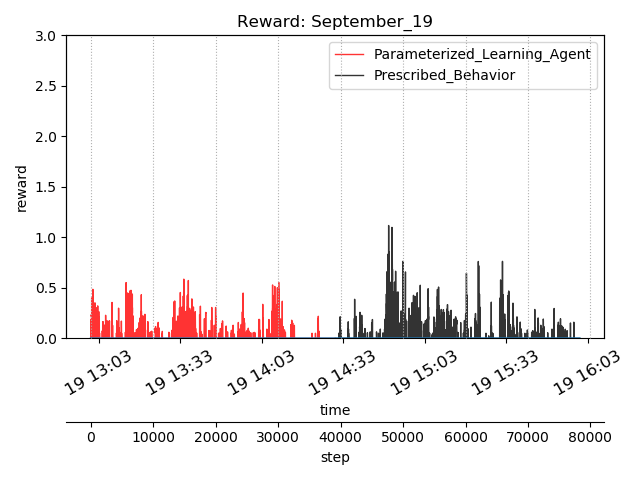

September_20
Separate data done!


<IPython.core.display.Javascript object>


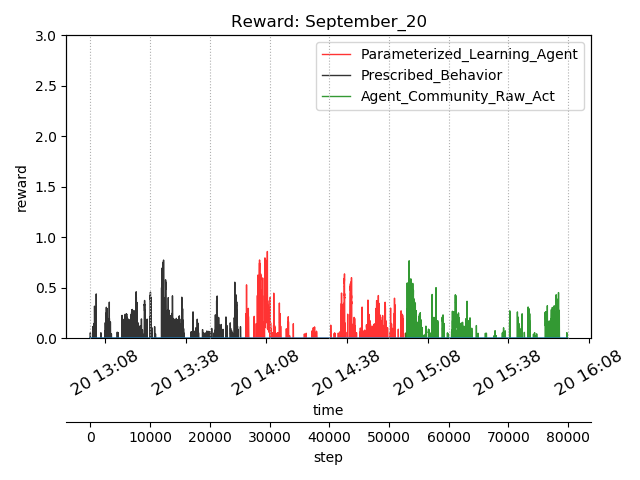

September_21
Separate data done!


<IPython.core.display.Javascript object>


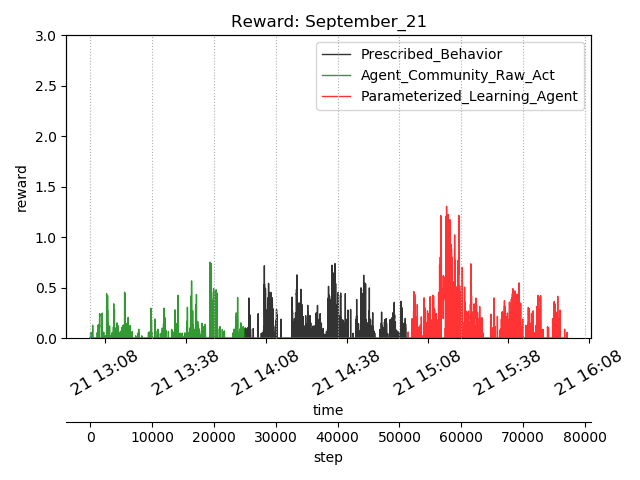

September_24
Separate data done!


<IPython.core.display.Javascript object>


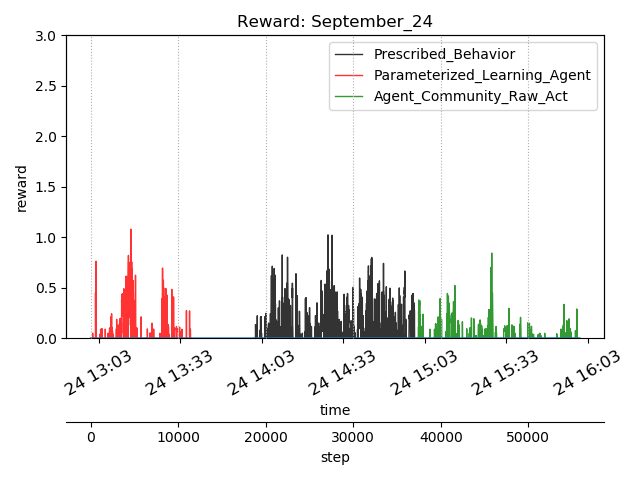

September_25
Separate data done!


<IPython.core.display.Javascript object>


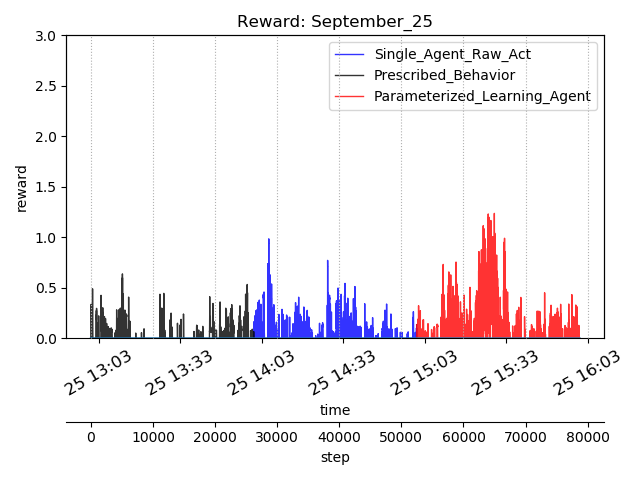

September_26
Separate data done!


<IPython.core.display.Javascript object>


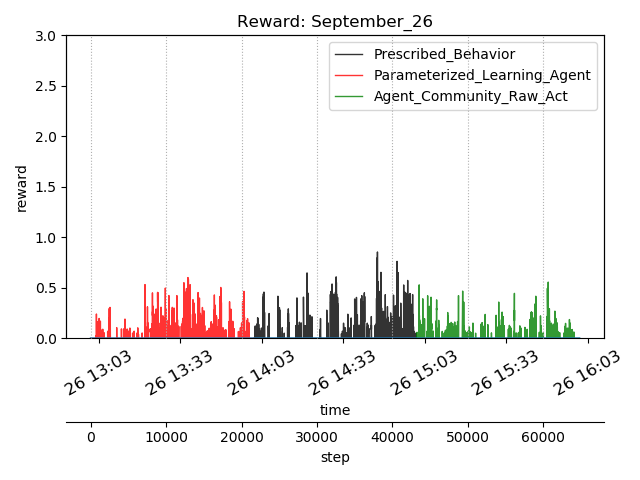

September_27
Separate data done!


<IPython.core.display.Javascript object>


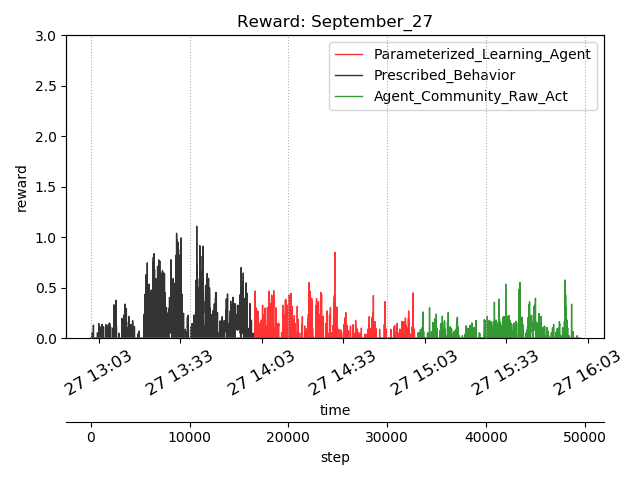

September_28
Separate data done!


<IPython.core.display.Javascript object>


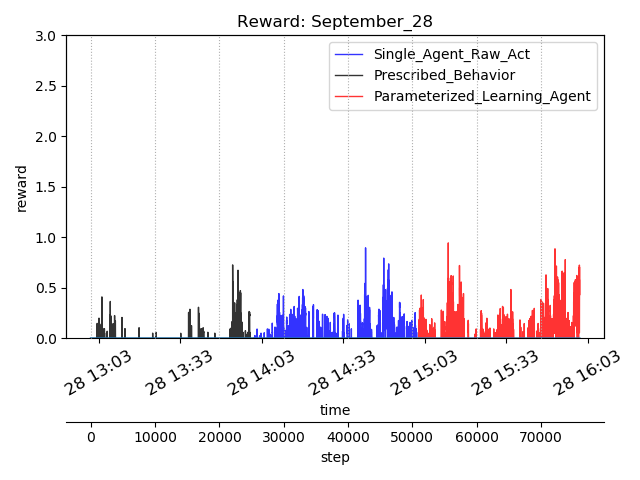

October_02
Separate data done!


<IPython.core.display.Javascript object>


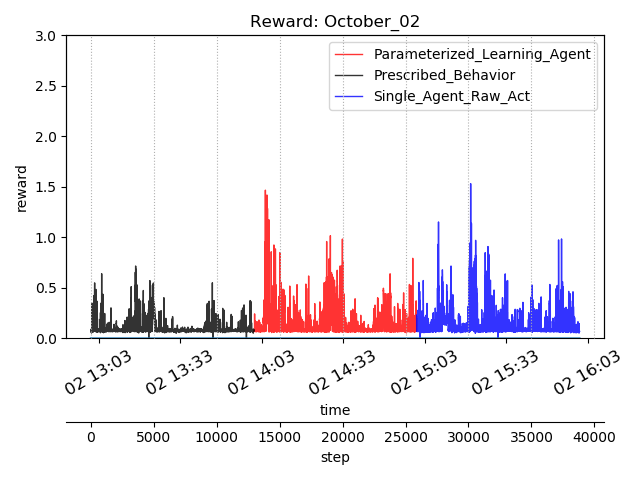

October_03
Separate data done!


<IPython.core.display.Javascript object>


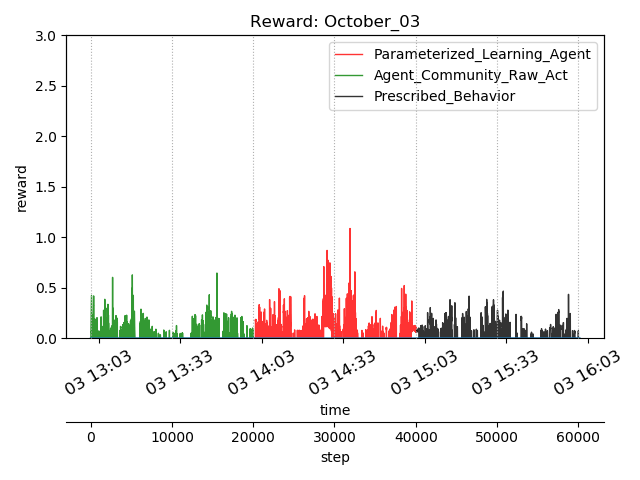

October_05
Separate data done!


<IPython.core.display.Javascript object>


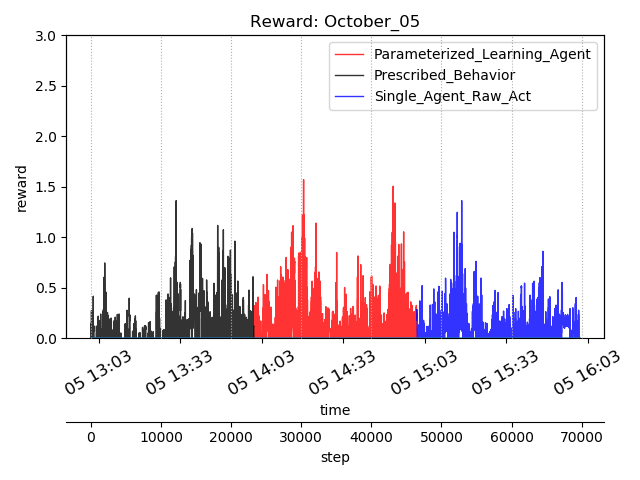

In [4]:
for file in raw_sensor_data.keys():
    _, filename = file.split('/')
    plot_reward_signal(raw_sensor_data[file], filename)

# Concate Data from the Same Behavior Mode

In [5]:
prescribed_behavior = {}
prescribed_behavior['data'] = pd.DataFrame()
prescribed_behavior['separate_line'] = []
prescribed_behavior['date'] = []

para_learning_agent = {}
para_learning_agent['data'] = pd.DataFrame()
para_learning_agent['separate_line'] = []
para_learning_agent['date'] = []

single_agent_raw_act = {}
single_agent_raw_act['data'] = pd.DataFrame()
single_agent_raw_act['separate_line'] = []
single_agent_raw_act['date'] = []

agent_coummunity_raw_act = {}
agent_coummunity_raw_act['data'] = pd.DataFrame()
agent_coummunity_raw_act['separate_line'] = []
agent_coummunity_raw_act['date'] = []

for file in raw_sensor_data.keys():
    _, filename = file.split('/')
    _, date = filename.split('_2018')[0].split('sensor_data__')
    
    phase_data, phase_code = separate_data_from_different_behavior(raw_sensor_data[file], date,
                                                                   experiment_schedule_table = 'experiment_schedule_table.csv')
    if 'September'in date:
        date = date.replace('September','Sep')
    elif 'October' in date:
        date = date.replace('October','Oct')
    else:
        pass
    for phase_name in phase_data.keys():
        if phase_code[phase_name] == 0:   # Prescribed_Behavior
            prescribed_behavior['data'] = pd.concat([prescribed_behavior['data'], phase_data[phase_name]])
            prescribed_behavior['separate_line'].append(len(prescribed_behavior['data']))
            
            prescribed_behavior['date'].append(date)
        elif phase_code[phase_name] == 1: # Parameterized_Learning_Agent
            para_learning_agent['data'] = pd.concat([para_learning_agent['data'], phase_data[phase_name]])
            para_learning_agent['separate_line'].append(len(para_learning_agent['data']))
            para_learning_agent['date'].append(date)
        elif phase_code[phase_name] == 2: # Single_Agent_Raw_Act
            single_agent_raw_act['data'] = pd.concat([single_agent_raw_act['data'], phase_data[phase_name]])
            single_agent_raw_act['separate_line'].append(len(single_agent_raw_act['data']))
            single_agent_raw_act['date'].append(date)
        elif phase_code[phase_name] == 3: # Agent_Community_Raw_Act
            agent_coummunity_raw_act['data'] = pd.concat([agent_coummunity_raw_act['data'], phase_data[phase_name]])
            agent_coummunity_raw_act['separate_line'].append(len(agent_coummunity_raw_act['data']))
            agent_coummunity_raw_act['date'].append(date)
        else:                             # Dirty data
            pass

In [6]:
def plot_reward_from_one_behavior_mode(data, behavior_mode):
        plt.figure()
        plt.plot(np.arange(len(data['data']['reward_IR_distance'])), data['data']['reward_IR_distance'])
        plt.xlabel('Step')
        for i, separate_line in enumerate(data['separate_line']):
            plt.axvline(x = separate_line, color = 'k', linestyle=':')
            if i == 0:
                middle = data['separate_line'][i]*0.35
                plt.text(middle, 2, data['date'][i], rotation=90, verticalalignment='center')
            else:
                middle = data['separate_line'][i-1]+(data['separate_line'][i]-data['separate_line'][i-1])*0.35
                plt.text(middle, 2, data['date'][i], rotation=90, verticalalignment='center')
        rect = patches.Rectangle((0,0.5), len(data['data']['reward_IR_distance']), 1, fill = False, color = 'r', linestyle='--',linewidth = 2)
        ax = plt.gca()
        ax.add_patch(rect)
        plt.ylabel('Reward')
        plt.ylim(0,2.5,0.25)
        plt.title('Reward: {}'.format(behavior_mode))
        #plt.grid(True)
        #plt.tight_layout()

In [7]:
def plot_reward_from_one_behavior_mode(data, behavior_mode):
        reward_data = data['data']['reward_IR_distance'].astype(float).values
        
        fig = plt.figure(figsize=(8, 6))
        grid = plt.GridSpec(1, 3, hspace=0.2, wspace=0.2)
        main_ax = fig.add_subplot(grid[:, 1:3])
        y_hist = fig.add_subplot(grid[:, 0:1], sharey=main_ax)
        # plot reward
        main_ax.plot(np.arange(len(reward_data)), reward_data)
        for i, separate_line in enumerate(data['separate_line']):
            main_ax.axvline(x = separate_line, color = 'k', linestyle=':')
            if i == 0:
                middle = data['separate_line'][i]*0.35
                main_ax.text(middle, 2, data['date'][i], rotation=90, verticalalignment='center')
            else:
                middle = data['separate_line'][i-1]+(data['separate_line'][i]-data['separate_line'][i-1])*0.35
                main_ax.text(middle, 2, data['date'][i], rotation=90, verticalalignment='center')
        rect = patches.Rectangle((0,0.5), len(reward_data), 1.25, fill = False, color = 'r', linestyle='--',linewidth = 2)
        main_ax.add_patch(rect)
        main_ax.set_xlabel('Step')
        for label in main_ax.get_xticklabels():
            label.set_rotation(20) 
        main_ax.set_ylabel('Reward')
        main_ax.set_ylim(0,2.5,0.25)
        main_ax.set_title('Reward: {}'.format(behavior_mode))
        # plot hist
        hist_reward_threshold = 0.5#1.0#0.75
        hist_data = reward_data[reward_data>=hist_reward_threshold]
        results, edges = np.histogram(hist_data, bins = 100)
        percentage = (results / sum(results)) * 100
        binWidth = 0.05
        y_hist.barh(edges[:-1], percentage, binWidth)
        from matplotlib.ticker import FuncFormatter
        formatter = FuncFormatter(lambda y, pos: "%d%%" % (y))
        y_hist.xaxis.set_major_formatter(formatter)
        y_hist.set_xlim(0,10)
        y_hist.set_xlabel('Percentage')
        y_hist.invert_xaxis()
        y_hist.set_title('Hist of reward >={}'.format(hist_reward_threshold))
        y_hist.grid(True, linestyle=':')


**Comparing the following 4 figures, if we regard reward greater than 0.5 as reaching hand, it seems prescribed behavior and learning agent acting on parameterized action space are more interactive than the two algorithms working on raw actuators.**

<IPython.core.display.Javascript object>


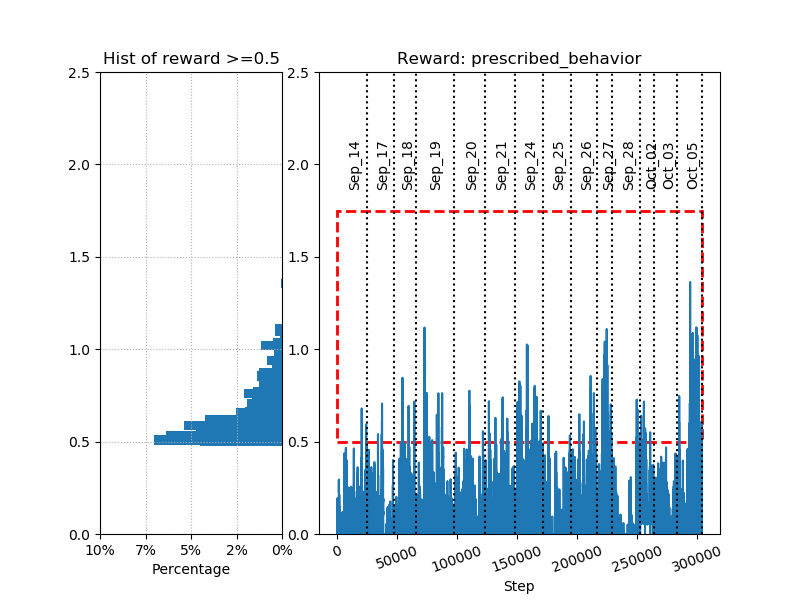

<IPython.core.display.Javascript object>


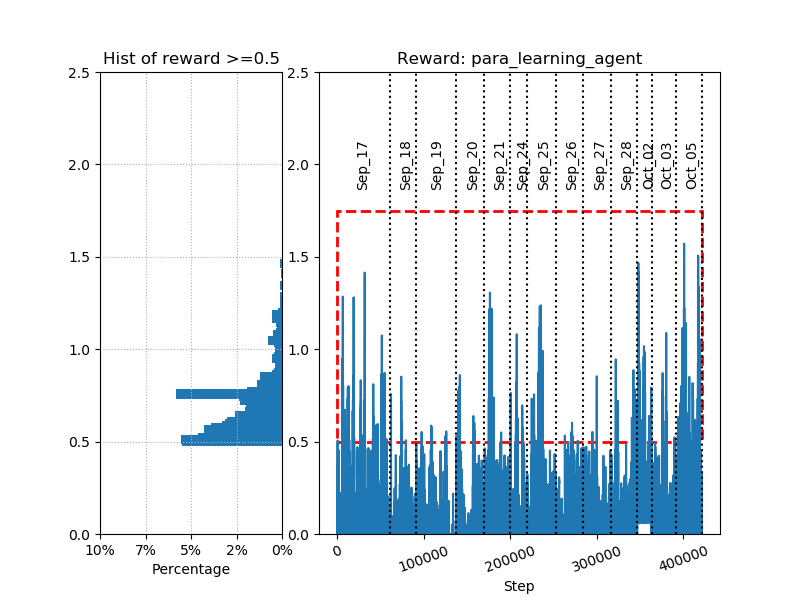

<IPython.core.display.Javascript object>


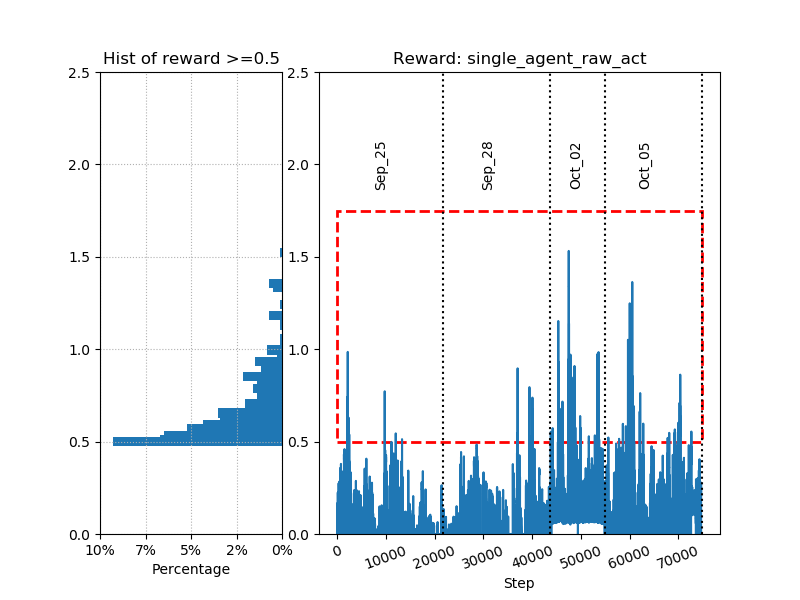

<IPython.core.display.Javascript object>


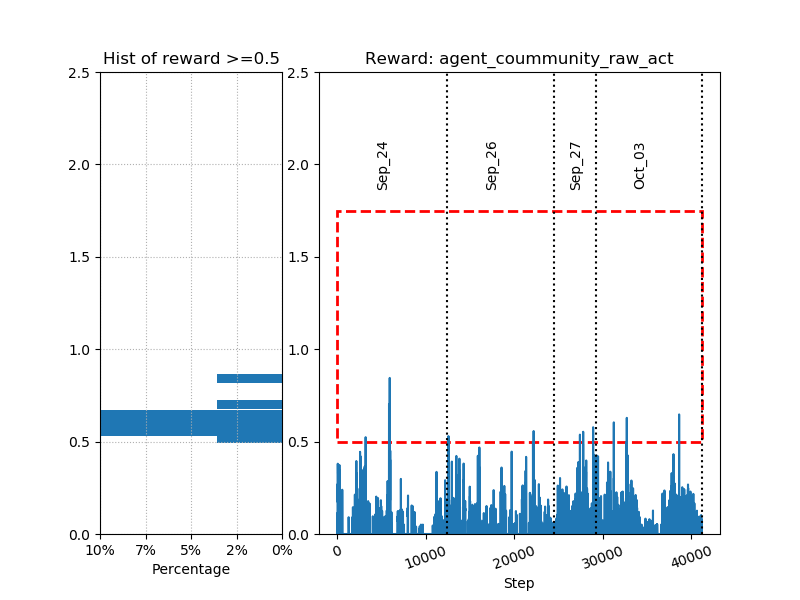

In [8]:
plot_reward_from_one_behavior_mode(prescribed_behavior, 'prescribed_behavior')
plot_reward_from_one_behavior_mode(para_learning_agent, 'para_learning_agent')
plot_reward_from_one_behavior_mode(single_agent_raw_act, 'single_agent_raw_act')
plot_reward_from_one_behavior_mode(agent_coummunity_raw_act, 'agent_coummunity_raw_act')